In [1]:
from IPython import display
import random
import numpy as np
import torch
import pickle
import timeit
import time
import argparse
import pprint
from pathlib import Path
from confs import fn, fn2
#from tqdm import tqdm_notebook as tqdm
from tqdm.notebook import tqdm
import numpy.random as npr
from utilsNew import *

In [2]:
import matplotlib.pyplot as plt
import pickle

In [4]:
from implicit.als import AlternatingLeastSquares
from collections import defaultdict as ddict
from scipy.sparse import csr_matrix 
from implicit.nearest_neighbours import bm25_weight

In [5]:
cudaid = 2
torch.cuda.set_device(cudaid)
torch.manual_seed(0) # cpu
torch.cuda.manual_seed(0) #gpu
np.random.seed(0) #numpy
random.seed(0) #random and transforms
torch.backends.cudnn.deterministic=True # cudnn

In [6]:
torch.set_default_dtype(torch.float64)
cuda = torch.cuda.is_available()
if cuda:
    torch.set_default_tensor_type(torch.cuda.DoubleTensor)

In [7]:
def fRun(R, Cb, etaT, etab, Rall, maxIter=100, nR=16, a=0.1, is_plot=False, is_showPro=False, is_res=False):
    #LamT = LamTfn(CT, n, m, p)
    LamT = 0
    #Lamb = 0
    Lamb = Lambfn(Cb, n, m)
    betaOld, bThetaOld = betainit, bThetainit
    
    
    reCh = 10
    Losses = []
    betaDiffs = []
    bThetaDiffs = []
    betaNorms = []
    bThetaNorms = []
    betaL0s = []
    bThetaRanks = []
    
    if is_showPro:
        IterShowBar = tqdm(range(maxIter))
    else:
        IterShowBar = range(maxIter)
    for t in IterShowBar:
        t0 = time.time()
        #LvNow = lossLBern(bThetaOld, betaOld, f, X, Y, R, probs=probs, fct=fct, is_logf=False)
        LvNow = lossL(bThetaOld, betaOld, f, X, Y, R, is_logf=False, fct=fct)
        
        t1 = time.time()
        # update beta
        #LpbvOld = lossLpbBern(bThetaOld, betaOld, conDenfs[:3], X, Y, R, probs=probs, fct=fct)
        LpbvOld = lossLpb(bThetaOld, betaOld, conDenfs[:3], X, Y, R, fct=fct)
        betaNewRaw = betaOld - etab * LpbvOld
        #betaNew = betaNewRaw.clone()
        #betaNew[betaNew.abs()>=a] = betaNewRaw[betaNewRaw.abs()>=a].sign()*a
        betaNew = SoftTO(betaNewRaw, etab*Lamb)
       
        t2 = time.time()
        #LpTvOld = lossLpTBern(bThetaOld, betaNew, conDenfs[:3], X, Y, R, probs=probs, fct=fct)
        LpTvOld = lossLpT(bThetaOld, betaNew, conDenfs[:3], X, Y, R, fct=fct)
       
        t3 = time.time()
        # update Theta
        #svdres = torch.svd(bThetaOld-LpTvOld*etaT)
        svdres = torch.svd_lowrank(bThetaOld-LpTvOld*etaT, q=40) # it can be very  fast
        U, S, V =  svdres
        bThetaNew = U[:, :nR].matmul(torch.diag(S[:nR])).matmul(V[:, :nR].t())
        #softS = (S-LamT*etaT).clamp_min(0)
        #bThetaNew = U.matmul(torch.diag(softS)).matmul(V.t())
        
        LossNow = LossWP(LvNow, S, betaNew, LamT, Lamb)
        Losses.append(LossNow.item())
        t4 = time.time()
        
        ts = np.array([t0, t1, t2, t3, t4])
        #print(np.diff(ts), torch.matrix_rank(bThetaOld))
    
        if t >= 1:
            Lk1 = Losses[-1]
            Lk = Losses[-2]
            reCh = np.abs(Lk1-Lk)/np.max(np.abs((Lk, Lk1, 1))) 
        betaDiff = (betaOld-betaNew).norm().item()/(betaNew.norm().item()+1e-6)
        bThetaDiff = (bThetaOld-bThetaNew).norm().item()/(bThetaNew.norm().item()+1e-6)
        betaDiffs.append(betaDiff)
        bThetaDiffs.append(bThetaDiff)
        bThetaNorms.append(bThetaNew.norm().item())
        betaNorms.append(betaNew.norm().item())
        betaL0s.append(len(torch.nonzero(betaNew)))
        bThetaRanks.append(torch.linalg.matrix_rank(bThetaNew).item())
        
        betaOld, bThetaOld = betaNew, bThetaNew 
        #etaT = 10/LpTvOld.norm().item()
        etaT = etaT * 0.96
        etab = etab * 0.95
        if is_res:
            res = RankMetricIter(betaOld, bThetaOld, Rall, R)
            print(f"The rank metric is {res.item():.4f},", 
                  f"The L0 norm of beta is {len(betaNew.nonzero())},"
                  f"The norm of LpT is {LpTvOld.norm().item():.4e}.") 
        
        
        # plot res
        if t >= 1 and is_plot:
            plt.figure(figsize=[15, 5])
            
            plt.subplot(131)
            plt.xlim([0, maxIter])
            #plt.ylim([-10, 5])
            plt.title("Loss Diff")
            lossDifs = np.log(np.abs(np.diff(Losses)))
            plt.plot(list(range(0, t)), lossDifs)
            plt.scatter(t-1, lossDifs[-1], color="red", s=20)
            plt.axhline(y=np.log(tol), color="green", linewidth=2, linestyle='--')
            
            
            plt.subplot(132)
            plt.xlim([0, maxIter])
            #plt.ylim([0, p])
            plt.title("Theta Norm")
            plt.plot(list(range(0, t+1)), bThetaNorms)
            plt.scatter(t, bThetaNorms[-1], color="red", s=20)
            plt.text(t, bThetaNorms[-1], f"Theta norm is {bThetaNorms[-1]:.3f}")
            #plt.axhline(y=5, color="green", linewidth=2, linestyle='--')
            
            plt.subplot(133)
            plt.xlim([0, maxIter])
            #plt.ylim([0, np.min([n, m])])
            plt.title("beta norm")
            plt.plot(list(range(0, t+1)), betaNorms)
            plt.scatter(t, betaNorms[-1], color="red", s=20)
            plt.text(t, betaNorms[-1], f"Beta norm is {betaNorms[-1]:.3f}")
            
            #if (reCh >= tol) and ((bThetaDiff >= tolT) or (betaDiff >= tolb)) and (t<=(maxIter-1)):
            display.clear_output(wait=True)
            plt.pause(1e-7)
            
        if (reCh < tol):
            break
        if (bThetaDiff < tolT) and (betaDiff < tolb):
            break
    
    res = {}
    res["beta"] = betaNew.cpu().numpy()
    res["bTheta"] = bThetaNew.cpu().numpy()
    res["IterNum"] = t
    res["betaDiffs"] = betaDiffs
    res["bThetaDiffs"] = bThetaDiffs
    res["loss"] = Losses
    res["betaNorm0"] = len(torch.nonzero(betaNew))
    res["bThetaRank"] = torch.linalg.matrix_rank(bThetaNew).item()
    return res

In [79]:
def marfRun(R, Cb, etaT, etab, Rall, maxIter=100, nR=16, is_plot=False, is_showPro=False):
    #LamT = LamTfn(CT, n, m, p)
    Lamb = Lambfn(Cb, n, m)
    #Lamb = 0
    LamT = 0
    betaOld, bThetaOld = betainit, bThetainit
    
    
    reCh = 10
    Losses = []
    betaDiffs = []
    bThetaDiffs = []
    betaNorms = []
    bThetaNorms = []
    betaL0s = []
    bThetaRanks = []
    
    if is_showPro:
        IterShowBar = tqdm(range(maxIter))
    else:
        IterShowBar = range(maxIter)
    for t in IterShowBar:
        res = RankMetricIter(betaOld, bThetaOld, Rall, R)
        t0 = time.time()
        #LvNow = marLinearLossL(X, Y, R, bThetaOld, betaOld, sigma=sigmaY) 
        LvNow = marLossL(bThetaOld, betaOld, f, X, Y, R, is_logf=False)
        t1 = time.time()
       
        # update beta
        LpbvOld = marLossLpb(bThetaOld, betaOld, conDenfs[:3], X, Y, R)
        #print(LpbvOld.norm().item())
        betaNewRaw = betaOld - etab * LpbvOld
        #betaNew = betaNewRaw
        betaNew = SoftTO(betaNewRaw, etab*Lamb)
       
        t2 = time.time()
        LpTvOld = marLossLpT(bThetaOld, betaNew, conDenfs[:3], X, Y, R)
        # print(LpTvOld.norm().item())
        t3 = time.time()
        #svdres = torch.svd_lowrank(bThetaOld-LpTvOld*etaT, q=40) # it can be very  fast
        svdres = torch.svd(bThetaOld-LpTvOld*etaT)
        U, S, V =  svdres
        bThetaNew = U[:, :nR].matmul(torch.diag(S[:nR])).matmul(V[:, :nR].t())
        #softS = (S-LamT*etaT).clamp_min(0)
        #bThetaNew = U.matmul(torch.diag(softS)).matmul(V.t())
        
        LossNow = LossWP(LvNow, S[:nR], betaNew, LamT, Lamb)
        #LossNow = LossWP(LvNow, softS, betaNew, LamT, Lamb)
        Losses.append(LossNow.item())
        t4 = time.time()
        
        ts = np.array([t0, t1, t2, t3, t4])
        #print(np.diff(ts), torch.matrix_rank(bThetaOld))
        if False:
            print(f"The rank metric is {res.item():.4f},", 
                  f"The L0 norm of beta is {len(betaNew.nonzero())},"
                  f"The norm of LpT is {LpTvOld.norm().item():.4e}.") 
    
        if t >= 1:
            Lk1 = Losses[-1]
            Lk = Losses[-2]
            reCh = np.abs(Lk1-Lk)/np.max(np.abs((Lk, Lk1, 1))) 
        betaDiff = (betaOld-betaNew).norm().item()/(betaNew.norm().item()+1e-6)
        bThetaDiff = (bThetaOld-bThetaNew).norm().item()/(bThetaNew.norm().item()+1e-6)
        bThetaNorms.append(bThetaNew.norm().item())
        betaNorms.append(betaNew.norm().item())
        betaDiffs.append(betaDiff)
        bThetaDiffs.append(bThetaDiff)
        betaL0s.append(len(torch.nonzero(betaNew)))
        bThetaRanks.append(torch.linalg.matrix_rank(bThetaNew).item())
        
        betaOld, bThetaOld = betaNew, bThetaNew 
        etaT = etaT * 0.96
        etab = etab * 0.95
        
        
        # plot res
        if t >= 1 and is_plot:
            plt.figure(figsize=[15, 5])
            
            plt.subplot(131)
            plt.xlim([0, maxIter])
            #plt.ylim([-10, 5])
            plt.title("Loss Diff")
            lossDifs = np.log(np.abs(np.diff(Losses)))
            plt.plot(list(range(0, t)), lossDifs)
            plt.scatter(t-1, lossDifs[-1], color="red", s=20)
            plt.axhline(y=np.log(tol), color="green", linewidth=2, linestyle='--')
            
            
            plt.subplot(132)
            plt.xlim([0, maxIter])
            #plt.ylim([0, p])
            plt.title("Theta Norm")
            plt.plot(list(range(0, t+1)), bThetaNorms)
            plt.scatter(t, bThetaNorms[-1], color="red", s=20)
            plt.text(t, bThetaNorms[-1], f"Theta norm is {bThetaNorms[-1]:.3f}")
            #plt.axhline(y=5, color="green", linewidth=2, linestyle='--')
            
            plt.subplot(133)
            plt.xlim([0, maxIter])
            #plt.ylim([0, np.min([n, m])])
            plt.title("beta norm")
            plt.plot(list(range(0, t+1)), betaNorms)
            plt.scatter(t, betaNorms[-1], color="red", s=20)
            plt.text(t, betaNorms[-1], f"Beta norm is {betaNorms[-1]:.3f}")
            #plt.axhline(y=5, color="green", linewidth=2, linestyle='--')
            
            #if (reCh >= tol) and ((bThetaDiff >= tolT) or (betaDiff >= tolb)) and (t<=(maxIter-1)):
            display.clear_output(wait=True)
            plt.pause(1e-7)
            
        if (reCh < tol):
            break
        
        if (bThetaDiff < tolT) and (betaDiff < tolb):
            break
    
    res = {}
    res["beta"] = betaNew.cpu().numpy()
    res["bTheta"] = bThetaNew.cpu().numpy()
    res["IterNum"] = t
    res["betaDiffs"] = betaDiffs
    res["bThetaDiffs"] = bThetaDiffs
    res["loss"] = Losses
    res["betaNorm0"] = len(torch.nonzero(betaNew))
    res["bThetaRank"] = torch.linalg.matrix_rank(bThetaNew).item()
    return res

In [9]:
def GenMissing(Yraw, OR=0.03, y1ratio=0.5):
    """
    OR: observed ratio.
    y1ratio: num of 1 / (num of 1 and 0) in the removed part
    """
    # get the R
    R = Yraw.clone()
    R[Yraw!=0] = 1

    rawOR = R.sum()/R.numel()
    assert OR <= rawOR
    
    numrv = R.numel() * (rawOR-OR) # number of samples to remove
    numrv1 = int(numrv*y1ratio) # number of 1 to remove
    numrv0 = int(numrv) - numrv1 # number of 0 to remove

    mask1 = (Yraw > 4.5) & (R==1) # matrix with observed 1 as True
    mask0 = (Yraw < 4.5) & (R==1) # matrix with observed 0 as True
    selidx1 = np.random.choice(int(torch.sum(mask1)), numrv1, replace=0)
    selidx0 = np.random.choice(int(torch.sum(mask0)), numrv0, replace=0)

    tmp1 = R[mask1] 
    tmp1[selidx1] = 0
    R[mask1] = tmp1

    tmp0 = R[mask0] 
    tmp0[selidx0] = 0
    R[mask0] = tmp0

    return R.double().to_sparse()


In [10]:
def RankMetric(res, R, Rtrain):
    eProbs = X.to_dense().matmul(torch.tensor(res["beta"])) + torch.tensor(res["bTheta"])
    Rdiff = R.to_dense() - Rtrain.to_dense()
    eProbsQ = eProbs.argsort(axis=1, descending=True).argsort(axis=1)/eProbs.shape[1]
    testProbsQ = eProbsQ[Rdiff==1]
    testYraw = Yraw.to_dense()[Rdiff==1]
    metric = torch.sum(testProbsQ * testYraw)/torch.sum(testYraw)
    return metric

In [11]:
def RankMetricIter(beta, bTheta, R, Rtrain):
    eProbs = X.to_dense().matmul(beta) + bTheta
    Rdiff = R.to_dense() - Rtrain.to_dense()
    eProbsQ = eProbs.argsort(axis=1, descending=True).argsort(axis=1)/eProbs.shape[1]
    testProbsQ = eProbsQ[Rdiff==1]
    testYraw = Yraw.to_dense()[Rdiff==1]
    metric = torch.sum(testProbsQ * testYraw)/torch.sum(testYraw)
    return metric

In [12]:
def RankMetricALS(res, R, Rtrain):
    eProbs = torch.tensor(np.matmul(res.item_factors, res.user_factors.T))
    Rdiff = R.to_dense() - Rtrain.to_dense()
    eProbsQ = eProbs.argsort(axis=1, descending=True).argsort(axis=1)/eProbs.shape[1]
    testProbsQ = eProbsQ[Rdiff==1]
    testYraw = Yraw.to_dense()[Rdiff==1]
    metric = torch.sum(testProbsQ * testYraw)/torch.sum(testYraw)
    return metric

### Load the data

In [13]:
datDir = Path("./RealData//JMLR-R1")

In [14]:
with open(datDir/"Xmat.pkl", "rb") as f:
    Xarr = pickle.load(f)
with open(datDir/"Ymat.pkl", "rb") as f:
    YrawArr = pickle.load(f)

YrawArr[YrawArr==-1] = 0
means = Xarr.mean(axis=(0, 1))
stds = Xarr.std(axis=(0, 1))
Xarr = (Xarr-means)/stds

In [16]:
X = torch.tensor(Xarr).double().to_sparse()
Yraw = torch.tensor(YrawArr).double().to_sparse()
R = (Yraw.to_dense() != 0).int().to_sparse()
Y = Yraw.clone().to_dense()

ym = Y[R.to_dense().bool()].mean()
yst = Y[R.to_dense().bool()].std()
Y = (Y-ym)/yst

## WFS tuning

In [25]:
numFcts = [1, 2, 4, 8, 16, 32, 64, 128]
K1s = [1.2, 1.4, 1.6, 1.8, 2.0]

In [26]:
ressALS = []
for K1 in tqdm(K1s, desc="Main loop"):
    resALS = ddict(list)
    for numFct in tqdm(numFcts):
        for i in range(10):
            # remove some data
            Rtrain = GenMissing(Yraw.to_dense(), 0.05, 0.65)
            Yn = Yraw.clone().to_dense()
            Yn[Rtrain.to_dense()==0] = 0
            
            # obtain data for training
            YtrainArr = csr_matrix(Yn.cpu().numpy())
            YtrainArr.data[YtrainArr.data < 1] = 0
            YtrainArr.eliminate_zeros()
            YtrainArr = bm25_weight(YtrainArr, B=0.75, K1=K1).tocsr()
            
            ALSmodel = AlternatingLeastSquares(numFct, use_gpu=False)
            ALSmodel.fit(YtrainArr, show_progress=False)
            
            res = RankMetricALS(ALSmodel, R, Rtrain)
            resALS[numFct].append(res.item())
    ressALS.append(resALS)

Main loop:   0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

In [28]:
ressMeans = []
ressVars = []

for resALS in ressALS:
    ressMean = []
    ressVar = []
    for numFct in numFcts:
        resMean = torch.tensor(resALS[numFct]).mean()
        resVar = torch.tensor(resALS[numFct]).var()
        ressMean.append(resMean.item())
        ressVar.append(resVar.item())
    ressMeans.append(ressMean)
    ressVars.append(ressVar)

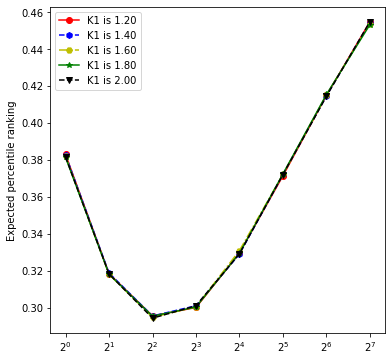

In [30]:
pchs = ["o-r", "h--b", "H-.y", "*-g", "v--k"]
plt.figure(figsize=[6, 6])
for idx in range(len(ressMeans)):
    ressMean = ressMeans[idx]
    plt.plot(numFcts, ressMean, pchs[idx], label=f"K1 is {K1s[idx]:.2f}")
#plt.text(optNumFct, minErr, f"The optimal num is {optNumFct}.")
plt.ylabel("Expected percentile ranking")
plt.xscale("log", base=2)
plt.legend()

In [45]:
ressMeans = np.array(ressMeans)
idxss = np.unravel_index(ressMeans.argmin(), ressMeans.shape)
optK1 = K1s[idxss[0]]
optNumFct = numFcts[idxss[1]]
print(f"Optimal K1 is {K1s[idxss[0]]}, "
      f"optimal num of facts is  {numFcts[idxss[1]]}, "
      f"optimal ranking is {ressMeans.min():.4f}.")

Optimal K1 is 2.0, optimal num of facts is  4, optimal ranking is 0.2944.


In [158]:
with open("./JMLRR2/YelpWCFTuning.pkl", "wb") as wf:
    pickle.dump(ressMeans, wf)

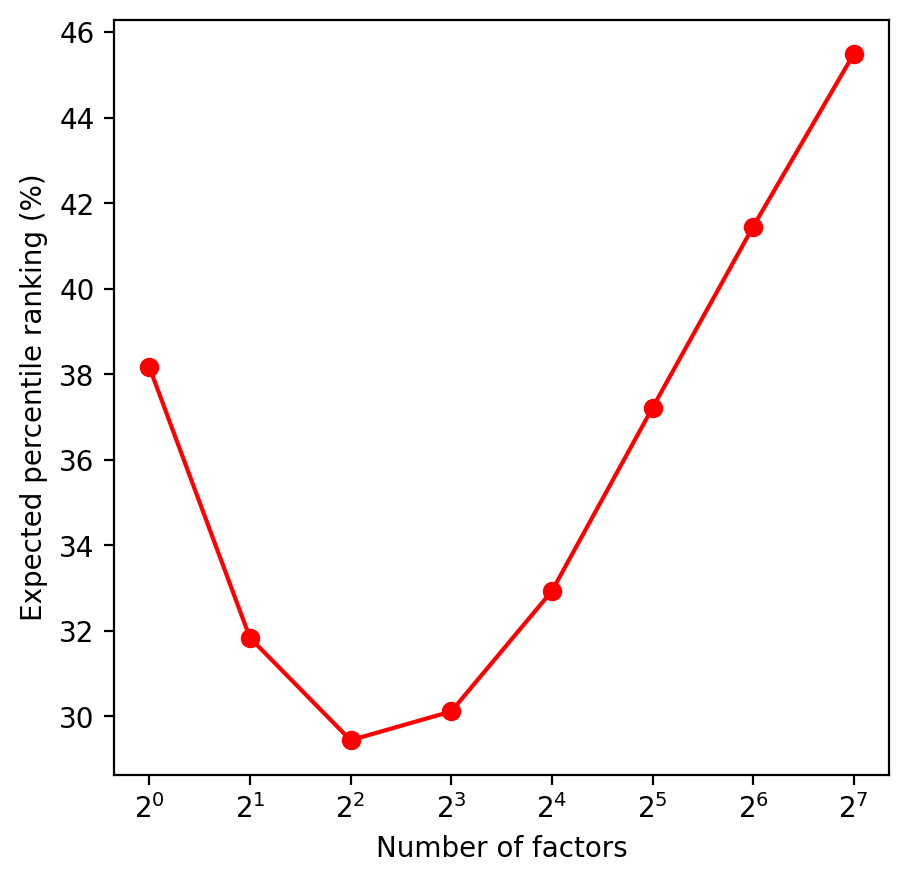

In [154]:
optMeans = ressMeans[idxss[0], :]
plt.figure(figsize=[5, 5], dpi=200)
plt.plot(numFcts, optMeans*100, "o-r")
plt.ylabel("Expected percentile ranking (%)")
plt.xlabel("Number of factors")
plt.xscale("log", base=2)
plt.savefig("./JMLRR2/YelpWCF.jpg", bbox_inches='tight')

### Tuning MNAR

In [104]:
n, m, p = X.shape
tol = 0
tolT = tolb = 0

In [105]:
sigmaY =2.0
def f(y, m, bsXs=None, sigma=sigmaY):
    return fn(y, m, bsXs, sigma)
def f2(y, m, bsXs=None, sigma=sigmaY):
    return fn2(y, m, bsXs, sigma)
conDenfs = [f, f2, f2]

In [106]:
paraXs = [
    [10, 1e4, 1000], 
    [10, 1e4, 100], 
    [10, 1e4, 10], 
    [10, 1e3, 100], 
    [10, 1e5, 100], 
    [5, 1e4, 100], 
    [1, 1e4, 100], 
]
fct = 10

In [ ]:
resMNARss = []
for paraX in tqdm(paraXs, desc="Main Loop"):
    etab, etaT, Cb = paraX
    resMNARs = []
    for i in tqdm(range(10), desc="Inner Loop"):
        betainit = torch.zeros(p) 
        bThetainit = torch.rand(n, m)
        Rtrain = GenMissing(Yraw.to_dense(), 0.05, 0.65)
        resMAR = marfRun(Rtrain, Rall=R, Cb=0, etaT=1e6, etab=0, maxIter=50, nR=4, is_plot=0, is_showPro=0)
        bThetainit = torch.tensor(resMAR['bTheta'])
        betainit = torch.tensor(resMAR['beta'])
        resMNAR = fRun(Rtrain, Rall=R, etaT=etaT, etab=etab, Cb=Cb, maxIter=50, a=0.5, nR=4, is_plot=0, is_showPro=0, is_res=0)
        resMNARs.append(RankMetric(resMNAR, R, Rtrain).item())
    resMNARss.append((paraX, resMNARs))

In [115]:
resMs = [np.mean(resMNARs[1]) for resMNARs in resMNARss]
optX = resMNARss[np.argmin(resMs)][0]
print(f"The optimal parameters are {optX}, the ranking is {np.min(resMs):.4f}.")

The optimal parameters are [10, 10000.0, 10], the ranking is 0.2770.


### Compare ALS with MNAR

In [118]:
optK1 = 2.0
optNumFct = 4
etab, etaT, Cb = 10, 1e4, 10

In [119]:
resRanks = []
for i in tqdm(range(20), desc="Loop"):
    Rtrain = GenMissing(Yraw.to_dense(), 0.05, 0.65)
    Yn = Yraw.clone().to_dense()
    Yn[Rtrain.to_dense()==0] = 0
    
    # obtain data for training
    YtrainArr = csr_matrix(Yn.cpu().numpy())
    YtrainArr.data[YtrainArr.data < 1] = 0
    YtrainArr.eliminate_zeros()
    YtrainArr = bm25_weight(YtrainArr, B=0.75, K1=optK1).tocsr()
    
    ALSmodel = AlternatingLeastSquares(optNumFct, use_gpu=False)
    ALSmodel.fit(YtrainArr, show_progress=False)
    
    resALSrank = RankMetricALS(ALSmodel, R, Rtrain)
    
    betainit = torch.zeros(p) 
    bThetainit = torch.rand(n, m)
    resMAR = marfRun(Rtrain, Rall=R, Cb=0, etaT=1e6, etab=0, maxIter=50, nR=4, is_plot=0, is_showPro=0)
    bThetainit = torch.tensor(resMAR['bTheta'])
    betainit = torch.tensor(resMAR['beta'])
    resMNAR = fRun(Rtrain, Rall=R, etaT=etaT, etab=etab, Cb=Cb, maxIter=50, a=0.5, nR=4, is_plot=0, is_showPro=0, is_res=0)
    resMNARrank = RankMetric(resMNAR, R, Rtrain)
    
    resRanks.append([resALSrank, resMNARrank])

Loop:   0%|          | 0/20 [00:00<?, ?it/s]

In [124]:
resRanks = [[res[0].item(), res[1].item()] for res in resRanks]

In [129]:
ms = np.mean(resRanks, axis=0)
stds = np.std(resRanks, axis=0)

In [132]:
ups = ms + 1.96*stds
lowers = ms - 1.96*stds

In [133]:
print(f"95% CI for ALS is ({lowers[0]:.4f}, {ups[0]:.4f}).")

95% CI for ALS is (0.2897, 0.2999).


In [134]:
print(f"95% CI for MNAR is ({lowers[1]:.4f}, {ups[1]:.4f}).")

95% CI for MNAR is (0.2744, 0.2794).


In [157]:
with open("./JMLRR2/YelpFinalRes.pkl", "wb") as wf:
    pickle.dump(resRanks, wf)

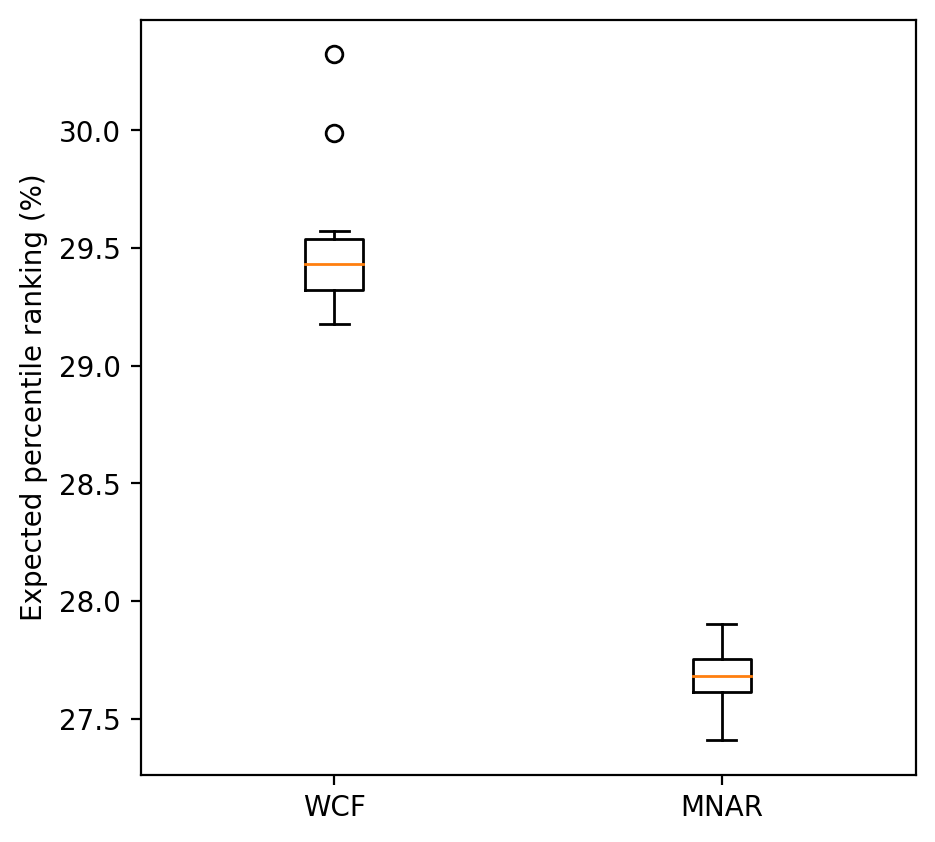

In [155]:
plt.figure(figsize=[5, 5], dpi=200)
plt.boxplot(np.array(resRanks)*100)
plt.ylabel("Expected percentile ranking (%)")
_ = plt.xticks([1, 2], ["WCF", "MNAR"])
plt.savefig("./JMLRR2/YelpBoxplot.jpg", bbox_inches='tight')